In [1]:
import sys
import os

# Chemin absolu ou relatif vers le dossier racine du projet (qui contient le dossier geocharge)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from geocharge.preprocessing import load_data, clean_data, parse_coords
from geocharge.regions import extract_departement, filter_by_ville
from geocharge.analysis import count_stations
from geocharge.visualization import generate_map, generate_heatmap

### 1. Script d'analyse des données manquantes

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_missing_data(df):
    """Analyse les données manquantes et les incohérences potentielles."""
    # Analyse des colonnes avec valeurs manquantes
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    
    # Visualisation
    plt.figure(figsize=(10, 6))
    missing_data.plot(kind='bar')
    plt.title('Colonnes avec valeurs manquantes')
    plt.ylabel('Nombre de valeurs manquantes')
    plt.xticks(rotation=45)
    plt.show()
    
    return missing_data

### 2. Script de vérification des villes non reconnues

In [4]:
def check_unrecognized_cities(df, sample_size=20):
    """Vérifie les villes qui n'ont pas été correctement normalisées."""
    # Récupère les adresses où la ville n'a pas pu être extraite
    unrecognized = df[df['ville_normalisee'].isna()]['adresse_station']
    
    print(f"Nombre d'adresses avec ville non reconnue: {len(unrecognized)}")
    print("\nExemples d'adresses problématiques:")
    for addr in unrecognized.sample(min(sample_size, len(unrecognized))):
        print(f"- {addr}")
    
    return unrecognized

### 3. Script de validation des coordonnées

In [5]:
def validate_coordinates(df):
    """Vérifie la validité des coordonnées géographiques."""
    # Vérifie les coordonnées invalides (hors de France)
    invalid_lat = ~df['latitude'].between(41, 52)
    invalid_lon = ~df['longitude'].between(-5, 10)
    
    print(f"Stations avec latitude potentiellement invalide: {invalid_lat.sum()}")
    print(f"Stations avec longitude potentiellement invalide: {invalid_lon.sum()}")
    
    if invalid_lat.any() or invalid_lon.any():
        print("\nExemples de stations avec coordonnées suspectes:")
        display(df[invalid_lat | invalid_lon][['nom_station', 'adresse_station', 'latitude', 'longitude']].head())
    
    return df[invalid_lat | invalid_lon]

### 4. Script de comparaison entre données attendues et affichées

In [6]:
def compare_expected_vs_displayed(df_main, df_filtered, filter_name):
    """Compare les données attendues et celles effectivement affichées."""
    # Comptage des stations
    total_main = len(df_main)
    total_filtered = len(df_filtered)
    
    print(f"Analyse pour: {filter_name}")
    print(f"- Stations totales: {total_main}")
    print(f"- Stations filtrées: {total_filtered}")
    print(f"- Pourcentage retenu: {total_filtered/total_main:.1%}")
    
    # Différence entre les datasets
    diff = set(df_main.index) - set(df_filtered.index)
    diff_df = df_main.loc[list(diff)]
    
    if not diff_df.empty:
        print("\nStations manquantes dans le filtre:")
        display(diff_df[['nom_station', 'adresse_station', 'ville_normalisee', 'departement']].head(10))
        
        # Analyse des raisons
        print("\nRaisons possibles:")
        if 'departement' in diff_df.columns:
            print(f"- Mauvais département: {diff_df['departement'].unique()}")
        if 'ville_normalisee' in diff_df.columns:
            print(f"- Villes non reconnues: {diff_df['ville_normalisee'].isna().sum()} stations")
        if 'autoroute' in diff_df.columns and filter_name == 'autoroutes':
            print(f"- Pas d'info autoroute: {diff_df['autoroute'].isna().sum()} stations")
    
    return diff_df

### 5. Script d'exploration des données par région

In [7]:
def explore_region_data(df, region_name, departements):
    """Explore les données pour une région spécifique."""
    print(f"\n=== Exploration pour la région: {region_name.upper()} ===")
    
    # Filtre les données
    region_df = df[df['departement'].isin(departements)]
    
    # Vérifie les villes non reconnues
    unrecognized = region_df[region_df['ville_normalisee'].isna()]
    print(f"\nVilles non reconnues dans {region_name}: {len(unrecognized)}")
    if not unrecognized.empty:
        print("Exemples:")
        for addr in unrecognized['adresse_station'].sample(min(5, len(unrecognized))):
            print(f"- {addr}")
    
    # Vérifie les coordonnées
    invalid_coords = region_df[
        ~region_df['latitude'].between(41, 52) | 
        ~region_df['longitude'].between(-5, 10)
    ]
    print(f"\nCoordonnées suspectes dans {region_name}: {len(invalid_coords)}")
    
    return region_df

### Exploration

c:\code\projets_perso\projets\GeoChargeAnalytics\geocharge\preprocessing.py:9: DtypeWarning: Columns (12,18,19,20,21,22,24,29,33) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath)


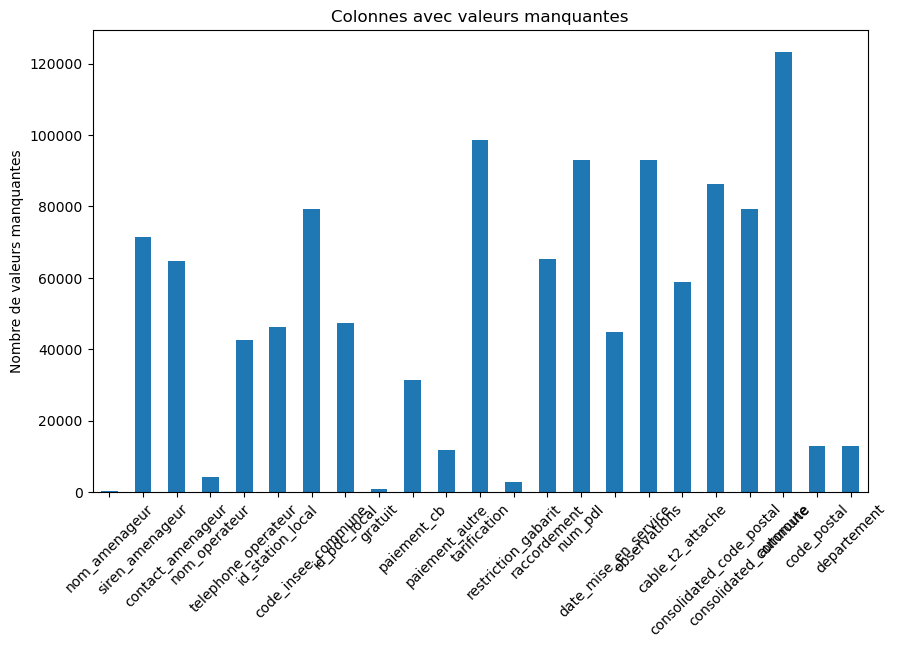

Nombre d'adresses avec ville non reconnue: 0

Exemples d'adresses problématiques:
Stations avec latitude potentiellement invalide: 513
Stations avec longitude potentiellement invalide: 553

Exemples de stations avec coordonnées suspectes:


,nom_station,adresse_station,latitude,longitude
8474,SAINT CLEMENT DE RIVIERE,"Carrefour Saint-Clément-De-Rivière, Route De G...",3.8419,4.649609
8476,SAINT CLEMENT DE RIVIERE,"Carrefour Saint-Clément-De-Rivière, Route De G...",3.8419,4.649609
8482,SAINT CLEMENT DE RIVIERE,"Carrefour Saint-Clément-De-Rivière, Route De G...",3.8419,4.649609
8484,SAINT CLEMENT DE RIVIERE,"Carrefour Saint-Clément-De-Rivière, Route De G...",3.8419,4.649609
8778,SAINT CLEMENT DE RIVIERE,"Carrefour Saint-Clément-De-Rivière, Route De G...",3.8419,4.649609


Analyse pour: IDF
- Stations totales: 129065
- Stations filtrées: 21492
- Pourcentage retenu: 16.7%

Stations manquantes dans le filtre:


,nom_station,adresse_station,ville_normalisee,departement
0,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
1,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
2,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
3,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
4,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
5,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
6,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
7,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
8,HAG_P21_Slave_4,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
9,HAG_P21_Slave_4,"Route de Bitche 93, 67500 Haguenau",Haguenau,67



Raisons possibles:
- Mauvais département: ['67' '80' '31' '32' '30' '61' '10' '18' '37' '40' '50' '55' '72' '34'
 '20' '13' nan '59' '74' '73' '47' '05' '69' '19' '33' '29' '62' '51' '60'
 '54' '57' '68' '42' '45' '56' '63' '08' '25' '21' '70' '90' '88' '89'
 '39' '81' '44' '06' '83' '84' '11' '17' '26' '35' '65' '01' '71' '15'
 '22' '12' '03' '82' '02' '64' '16' '87' '49' '85' '79' '27' '38' '24'
 '76' '14' '58' '04' '28' '41' '66' '53' '36' '23' '86' '43' '46' '07'
 '97' '09' '52' '48' '98']
- Villes non reconnues: 0 stations

=== Exploration pour la région: PARIS ===

Villes non reconnues dans Paris: 0

Coordonnées suspectes dans Paris: 0
Analyse pour: Autoroutes
- Stations totales: 129065
- Stations filtrées: 5814
- Pourcentage retenu: 4.5%

Stations manquantes dans le filtre:


,nom_station,adresse_station,ville_normalisee,departement
0,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
1,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
2,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
3,ACU_Poste_De_Garde_Haguenau,"93 route de Bitche, 67506 Haguenau Cedex",Haguenau Cedex,67
4,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
5,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
6,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
7,HAG_P22_Slave_3,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
8,HAG_P21_Slave_4,"Route de Bitche 93, 67500 Haguenau",Haguenau,67
9,HAG_P21_Slave_4,"Route de Bitche 93, 67500 Haguenau",Haguenau,67



Raisons possibles:
- Mauvais département: ['67' '80' '31' '32' '30' '91' '61' '10' '50' '55' '34' '94' '20' '13' nan
 '59' '95' '77' '74' '73' '47' '05' '69' '19' '33' '29' '62' '51' '60'
 '54' '57' '37' '68' '42' '45' '56' '63' '08' '25' '21' '70' '90' '88'
 '89' '39' '81' '44' '06' '78' '83' '84' '92' '11' '17' '26' '35' '65'
 '01' '71' '75' '15' '93' '22' '12' '03' '82' '02' '64' '72' '16' '87'
 '49' '27' '38' '24' '18' '76' '14' '85' '58' '04' '28' '41' '79' '66'
 '53' '36' '23' '40' '86' '43' '46' '07' '97' '09' '52' '48' '98']
- Villes non reconnues: 0 stations


In [9]:
# Chargement des données
from geocharge.preprocessing import load_data, clean_data
from geocharge.regions import extract_departement

df = load_data("../data/raw/consolidation-etalab-schema-irve-statique-v-2.3.1-20250608.csv")
df = clean_data(df)
df = extract_departement(df)

# 1. Analyse des données manquantes
missing_data = analyze_missing_data(df)

# 2. Vérification des villes non reconnues
unrecognized_cities = check_unrecognized_cities(df)

# 3. Validation des coordonnées
invalid_coords = validate_coordinates(df)

# 4. Comparaison pour l'IDF
from geocharge.regions import VILLE_DEPARTEMENTS

idf_df = df[df['departement'].isin(VILLE_DEPARTEMENTS['idf'])]
missing_in_idf = compare_expected_vs_displayed(df, idf_df, "IDF")

# 5. Exploration spécifique pour Paris
paris_df = explore_region_data(df, "Paris", VILLE_DEPARTEMENTS['paris'])

# 6. Exploration pour les autoroutes
autoroutes_df = df[df['autoroute'].notna()]
missing_autoroutes = compare_expected_vs_displayed(df, autoroutes_df, "Autoroutes")

In [14]:
df.columns

Index(['nom_amenageur', 'siren_amenageur', 'contact_amenageur',
       'nom_operateur', 'contact_operateur', 'telephone_operateur',
       'nom_enseigne', 'id_station_itinerance', 'id_station_local',
       'nom_station', 'implantation_station', 'adresse_station',
       'code_insee_commune', 'coordonneesXY', 'nbre_pdc', 'id_pdc_itinerance',
       'id_pdc_local', 'puissance_nominale', 'prise_type_ef', 'prise_type_2',
       'prise_type_combo_ccs', 'prise_type_chademo', 'prise_type_autre',
       'gratuit', 'paiement_acte', 'paiement_cb', 'paiement_autre',
       'tarification', 'condition_acces', 'reservation', 'horaires',
       'accessibilite_pmr', 'restriction_gabarit', 'station_deux_roues',
       'raccordement', 'num_pdl', 'date_mise_en_service', 'observations',
       'date_maj', 'cable_t2_attache', 'last_modified', 'datagouv_dataset_id',
       'datagouv_resource_id', 'datagouv_organization_or_owner', 'created_at',
       'consolidated_longitude', 'consolidated_latitude',
     

In [15]:
# Calcule le nombre total de lignes dans le DataFrame
total_rows = len(df)

# Crée une liste pour stocker les données de notre futur tableau
null_data = []

# Parcourt chaque colonne du DataFrame
for column in df.columns:
    # Compte le nombre de valeurs nulles dans la colonne actuelle
    null_count = df[column].isnull().sum()
    
    # Calcule le pourcentage de valeurs nulles
    # Gère le cas où total_rows pourrait être zéro pour éviter une division par zéro
    percentage_null = (null_count / total_rows) * 100 if total_rows > 0 else 0
    
    # Ajoute les informations à notre liste
    null_data.append({'Nom de la colonne': column, 'Pourcentage de valeurs nulles': percentage_null})

# Crée un nouveau DataFrame à partir de notre liste
df_null_percentage = pd.DataFrame(null_data)

# Affiche le tableau résultant
print(df_null_percentage)

                      Nom de la colonne  Pourcentage de valeurs nulles
0                         nom_amenageur                       0.285902
1                       siren_amenageur                      55.344981
2                     contact_amenageur                      50.046101
3                         nom_operateur                       3.269670
4                     contact_operateur                       0.000000
5                   telephone_operateur                      32.960911
6                          nom_enseigne                       0.000000
7                 id_station_itinerance                       0.000000
8                      id_station_local                      35.788944
9                           nom_station                       0.000000
10                 implantation_station                       0.000000
11                      adresse_station                       0.000000
12                   code_insee_commune                      61.400070
13    

### visualiser les problèmes d'adresses

In [10]:
def visualize_address_issues(df, sample_size=10):
    """Visualise les problèmes courants dans les adresses."""
    # Adresses sans code postal
    no_postal = df[df['code_postal'].isna()]
    print(f"Adresses sans code postal: {len(no_postal)}")
    if not no_postal.empty:
        print("Exemples:")
        for addr in no_postal['adresse_station'].sample(min(sample_size, len(no_postal))):
            print(f"- {addr}")
    
    # Adresses avec ville non reconnue
    no_city = df[df['ville_normalisee'].isna() & df['code_postal'].notna()]
    print(f"\nAdresses avec code postal mais ville non reconnue: {len(no_city)}")
    if not no_city.empty:
        print("Exemples:")
        for addr in no_city['adresse_station'].sample(min(sample_size, len(no_city))):
            print(f"- {addr}")
    
    # Adresses avec format inhabituel
    unusual_format = df[~df['adresse_station'].str.contains(r'\d{5}', na=False)]
    print(f"\nAdresses sans format de code postal standard: {len(unusual_format)}")
    if not unusual_format.empty:
        print("Exemples:")
        for addr in unusual_format['adresse_station'].sample(min(sample_size, len(unusual_format))):
            print(f"- {addr}")

In [11]:
problemes_adresses=visualize_address_issues(df)

Adresses sans code postal: 12883
Exemples:
- A6 - PARIS LYON
- 22 Route de Sélestat
- 486 Avenue de Nîmes
- Rue Saint Nicolas
- A71 - AIRE DES VOLCANS D' AUVERG
- 6 rue de la Guinotterie
- 17 Route de Sancerre
- Paul Joseph Barthez
- Boulevard Anatole France
- 33 Avenue de l'Europe

Adresses avec code postal mais ville non reconnue: 0

Adresses sans format de code postal standard: 12883
Exemples:
- Le Poteau de Maussac
- D19 Impasse Les Chênes
- 6 rue Annet Segeron
- 81 route d'Orléans
- 1792 Route de la Plaine
- Village Auto, 4 Rue des Ardennes
- 151 avenue François Verdier
- Rue Auguste Delaune, Zone Commerciale Intermarche
- 5005 CHEMIN DE QUILLA
- 1699 Avenue d'Italie
